<a href="https://colab.research.google.com/github/YoheiFukuhara/nlp100-2020/blob/main/09.RNN%2CCNN/84_%E5%8D%98%E8%AA%9E%E3%83%99%E3%82%AF%E3%83%88%E3%83%AB%E3%81%AE%E5%B0%8E%E5%85%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での[学習済み単語ベクトル](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)）で単語埋め込み$\mathrm{emb}(x)$を初期化し，学習せよ．

新しい記事
https://keras.io/examples/nlp/pretrained_word_embeddings/

少し古いがここの記事
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

解説系記事
https://work-in-progress.hatenablog.com/entry/2019/03/03/122058

In [ ]:
import numpy as np
import nltk
from gensim.models import KeyedVectors
import pandas as pd
import tensorflow as tf
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


!python --version
!pip show numpy gensim google tensorflow nltk pandas

In [ ]:
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/NLP100_2020/'
max_len = 0
vocabulary = []
w2v_model = KeyedVectors.load_word2vec_format(BASE_PATH+'07.WordVector/input/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
def read_dataset(type_):
    global max_len
    global vocabulary
    df = pd.read_table(BASE_PATH+'06.MachineLearning/'+type_+'.feature.txt')
    df.info()
    sr_title = df['title'].str.split().explode()
    max_len_ = df['title'].map(lambda x: len(x.split())).max()
    if max_len < max_len_:
        max_len = max_len_
    if len(vocabulary) == 0:
        vocabulary = [k for k, v in nltk.FreqDist(sr_title).items() if v > 1]
    else:
        vocabulary.extend([k for k, v in nltk.FreqDist(sr_title).items() if v > 1])
    y = df['category'].replace({'b':0, 't':1, 'e':2, 'm':3})
    return df['title'], tf.keras.utils.to_categorical(y, dtype='int32')  # 4値分類なので訓練・検証・テスト共通でone-hot化

In [ ]:
X_train, y_train = read_dataset('train')
X_valid, y_valid = read_dataset('valid')
X_test, y_test = read_dataset('test') # あまりこだわらずにテストデータセットも追加

# setで重複削除し、タプル形式に設定
tup_voc = tuple(set(vocabulary))

print(f'vocabulary size before removing duplicates: {len(vocabulary)}')
print(f'vocabulary size after removing duplicates: {len(tup_voc)}')
print(f'sample vocabulary: {tup_voc[:10]}')
print(f'max length is {max_len}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10684 entries, 0 to 10683
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     10684 non-null  object
 1   category  10684 non-null  object
dtypes: object(2)
memory usage: 167.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
vocabulary size before removing duplicates: 11089
vocabulary size after removing duplicates: 7802
sa

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
 output_mode='int',
 vocabulary=tup_voc,
 output_sequence_length=max_len)

print(f'vocabulary size is {vectorize_layer.vocabulary_size()}')

vocabulary size is 7804


In [ ]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
%%time
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

#https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.get_vector

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    try:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = w2v_model.get_vector(word)
        hits += 1
    except:
        misses += 1
        if misses < 7:
            print(word)

#    embedding_vector = w2v_model.get_vector(word)
#    if embedding_vector is not None:
#        embedding_matrix[i] = embedding_vector
#        hits += 1
#    else:
#        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


[UNK]
brandeis
S**t
barclay
Gox
Converted 7664 words (140 misses)
CPU times: user 40.6 ms, sys: 6.23 ms, total: 46.8 ms
Wall time: 45.7 ms


In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
)

In [ ]:
#https://www.tensorflow.org/text/guide/word_embeddings

# embeddingのデフォルトinitializerであるuniformはrandom_uniform
# https://github.com/keras-team/keras/blob/v2.7.0/keras/initializers/__init__.py#L116

# cuDNN を使うようにGRUは基本はデフォルト値
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(embedding_layer)
#model.add(w2v_model.get_keras_embedding(train_embeddings=False))
model.add(tf.keras.layers.GRU(50))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 18)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 18, 300)           2341800   
                                                                 
 gru_1 (GRU)                 (None, 50)                52800     
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                                 
Total params: 2,394,804
Trainable params: 53,004
Non-trainable params: 2,341,800
_________________________________________________________________


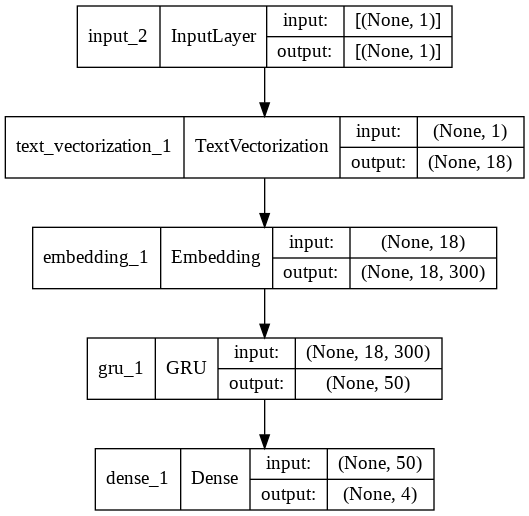

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
%%time
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
334/334 [==============================] - 3s 9ms/step - loss: 1.1614 - acc: 0.4244 - val_loss: 1.1617 - val_acc: 0.4214
Epoch 2/100
334/334 [==============================] - 3s 9ms/step - loss: 1.1613 - acc: 0.4262 - val_loss: 1.1614 - val_acc: 0.4214
Epoch 3/100
334/334 [==============================] - 3s 9ms/step - loss: 1.1611 - acc: 0.4246 - val_loss: 1.1615 - val_acc: 0.4903
Epoch 4/100
334/334 [==============================] - 3s 9ms/step - loss: 1.1609 - acc: 0.4287 - val_loss: 1.1613 - val_acc: 0.4731
Epoch 5/100
334/334 [==============================] - 3s 9ms/step - loss: 1.1608 - acc: 0.4276 - val_loss: 1.1609 - val_acc: 0.4439
Epoch 6/100
334/334 [==============================] - 3s 9ms/step - loss: 1.1605 - acc: 0.4320 - val_loss: 1.1605 - val_acc: 0.4229
Epoch 7/100
334/334 [==============================] - 3s 9ms/step - loss: 1.1602 - acc: 0.4321 - val_loss: 1.1603 - val_acc: 0.4461
Epoch 8/100
334/334 [==============================] - 3s 9ms/step - 

In [ ]:
model.evaluate(X_test, y_test)

42/42 [==============================] - 0s 5ms/step - loss: 0.4855 - acc: 0.8234


[0.48549962043762207, 0.8233532905578613]